In [1]:
import pandas as pd
import numpy as np

from cuh_resp_model.components.step1 import get_los_data
from cuh_resp_model.components.step3 import load_los

In [2]:
los_data = get_los_data('data/patients_covid.xlsx')[0]
los_df = load_los(los_data)
los_df

,Age,Admission,Discharge,ReAdmission,ReAdmissionDisch,LOS,LOS_ReAdmission,LOS_Total
0,88,2021-12-01 07:35:11.104,2021-12-01 12:08:15.104,2021-12-13 13:37:28.576,2021-12-13 16:45:20.768,0 days 04:33:04,0 days 03:07:52.192000,0.320095
3,48,2021-12-01 16:50:03.392,2021-12-07 19:29:21.408,2021-12-13 16:34:25.408,2021-12-19 09:26:05.056,6 days 02:39:18.016000,5 days 16:51:39.648000,11.813167
4,39,2021-12-01 17:42:29.120,2021-12-04 18:59:57.056,NaT,NaT,3 days 01:17:27.936000,0 days 00:00:00,3.053796
5,72,2021-12-01 21:23:07.392,2021-12-23 14:39:05.216,NaT,NaT,21 days 17:15:57.824000,0 days 00:00:00,21.719419
6,73,2021-12-02 06:37:59.680,2021-12-02 20:04:05.248,NaT,NaT,0 days 13:26:05.568000,0 days 00:00:00,0.559787
...,...,...,...,...,...,...,...,...
5613,78,2024-05-30 22:33:41.632,2024-06-03 16:44:46.976,NaT,NaT,3 days 18:11:05.344000,0 days 00:00:00,3.757701
5615,75,2024-05-31 17:20:54.784,2024-06-02 16:34:15.168,NaT,NaT,1 days 23:13:20.384000,0 days 00:00:00,1.967597
5617,80,2024-06-03 11:38:56.896,2024-06-13 18:34:27.200,NaT,NaT,10 days 06:55:30.304000,0 days 00:00:00,10.288545
5618,88,2024-06-03 17:52:30.208,2024-06-12 11:59:26.720,NaT,NaT,8 days 18:06:56.512000,0 days 00:00:00,8.754821


In [3]:
from scipy.stats import zscore

los_paeds = np.array(los_df.loc[los_df.Age < 16, 'LOS_Total'])
print('Shape before filtering:', los_paeds.shape)

los_paeds = los_paeds[np.abs(zscore(los_paeds)) < 3]
print('Shape after filtering:', los_paeds.shape)

Shape before filtering: (275,)
Shape after filtering: (269,)


In [4]:
import fitter

f = fitter.Fitter(los_paeds, timeout=10)
f.fit()

2025-04-15 14:11:58.936 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 10 seconds)
2025-04-15 14:11:58.959 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.392996)
2025-04-15 14:11:58.965 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.018194)
2025-04-15 14:11:58.967 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.066168)
2025-04-15 14:11:58.977 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.085925)
2025-04-15 14:11:58.980 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.415958)
2025-04-15 14:11:58.981 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.0859)
2025-04-15 14:11:58.985 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

In [5]:
fit_df = f.df_errors.sort_values('sumsquare_error')[['sumsquare_error', 'aic', 'bic', 'ks_pvalue']]
fit_df = fit_df.loc[np.isfinite(fit_df.sumsquare_error)].sort_values('sumsquare_error')
fit_df

,sumsquare_error,aic,bic,ks_pvalue
alpha,0.018194,1084.420255,1095.204389,9.310873e-01
genextreme,0.018239,1098.483219,1109.267353,8.245248e-01
invweibull,0.018239,1098.484645,1109.268779,8.244847e-01
invgamma,0.018397,1100.109456,1110.893590,8.078030e-01
nct,0.018410,1103.591174,1117.970020,7.345426e-01
...,...,...,...,...
levy_l,0.442313,964.936625,972.126047,5.091076e-100
trapezoid,0.481849,811.919564,826.298409,1.477764e-189
trapz,0.481849,811.919564,826.298409,1.477764e-189
weibull_max,0.661410,1068.168012,1078.952146,4.354381e-194


In [6]:
fit_df['dist_mean'] = np.nan
fit_df['dist_std'] = np.nan
fit_df

,sumsquare_error,aic,bic,ks_pvalue,dist_mean,dist_std
alpha,0.018194,1084.420255,1095.204389,9.310873e-01,NaN,NaN
genextreme,0.018239,1098.483219,1109.267353,8.245248e-01,NaN,NaN
invweibull,0.018239,1098.484645,1109.268779,8.244847e-01,NaN,NaN
invgamma,0.018397,1100.109456,1110.893590,8.078030e-01,NaN,NaN
nct,0.018410,1103.591174,1117.970020,7.345426e-01,NaN,NaN
...,...,...,...,...,...,...
levy_l,0.442313,964.936625,972.126047,5.091076e-100,NaN,NaN
trapezoid,0.481849,811.919564,826.298409,1.477764e-189,NaN,NaN
trapz,0.481849,811.919564,826.298409,1.477764e-189,NaN,NaN
weibull_max,0.661410,1068.168012,1078.952146,4.354381e-194,NaN,NaN


In [7]:
from scipy import stats

In [8]:
for dist_name in fit_df.index:
    dist = getattr(stats, dist_name)(*f.fitted_param[dist_name])
    fit_df.loc[dist_name, 'dist_mean'] = dist.mean()
    fit_df.loc[dist_name, 'dist_std'] = dist.std()

fit_df

/home/yinchi/Desktop/git_projects/cuh-resp-model/.venv/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:1451: RuntimeWarning: invalid value encountered in sqrt
  res = sqrt(self.stats(*args, **kwds))
/home/yinchi/Desktop/git_projects/cuh-resp-model/.venv/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/home/yinchi/Desktop/git_projects/cuh-resp-model/.venv/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:1401: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(0.77025959).
  res = self.stats(*args, **kwds)
/home/yinchi/Desktop/git_projects/cuh-resp-mod

,sumsquare_error,aic,bic,ks_pvalue,dist_mean,dist_std
alpha,0.018194,1084.420255,1095.204389,9.310873e-01,inf,inf
genextreme,0.018239,1098.483219,1109.267353,8.245248e-01,8.965130,NaN
invweibull,0.018239,1098.484645,1109.268779,8.244847e-01,8.965143,NaN
invgamma,0.018397,1100.109456,1110.893590,8.078030e-01,7.385547,inf
nct,0.018410,1103.591174,1117.970020,7.345426e-01,11.388911,NaN
...,...,...,...,...,...,...
levy_l,0.442313,964.936625,972.126047,5.091076e-100,inf,inf
trapezoid,0.481849,811.919564,826.298409,1.477764e-189,28.100214,11.380136
trapz,0.481849,811.919564,826.298409,1.477764e-189,28.100214,11.380136
weibull_max,0.661410,1068.168012,1078.952146,4.354381e-194,2.688729,307.116907


In [9]:
print(np.mean(los_paeds), np.std(los_paeds))

4.422625405479829 6.521927824692987


In [15]:
fit_df = fit_df.loc[np.isfinite(fit_df.dist_std) & (fit_df.dist_mean > 0) & (fit_df.dist_std > 0.5 * np.std(los_paeds)) & (fit_df.dist_std < 1.5 * np.std(los_paeds))]
fit_df[:5]

,sumsquare_error,aic,bic,ks_pvalue,dist_mean,dist_std
norminvgauss,0.018943,1078.786269,1093.165115,0.803913,4.422614,7.515703
genhyperbolic,0.020575,1075.670819,1093.644375,0.743854,4.422725,7.169285
geninvgauss,0.021803,1082.890972,1097.269818,0.481002,4.422620,7.510174
invgauss,0.025928,1075.298940,1086.083074,0.252460,4.422654,6.937091
gibrat,0.031194,1189.207144,1196.396567,0.056885,3.634783,4.797730


In [11]:
list(fit_df.index[:5])

['norminvgauss', 'genhyperbolic', 'geninvgauss', 'invgauss', 'gibrat']

In [12]:
f2 = fitter.Fitter(los_paeds, distributions=list(fit_df.index[:5]))
f2.fit()

2025-04-15 14:12:12.278 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gibrat distribution with error=0.031194)
2025-04-15 14:12:12.278 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted invgauss distribution with error=0.025928)
2025-04-15 14:12:12.338 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted geninvgauss distribution with error=0.021803)
2025-04-15 14:12:12.415 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted genhyperbolic distribution with error=0.020575)
2025-04-15 14:12:12.459 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norminvgauss distribution with error=0.018943)


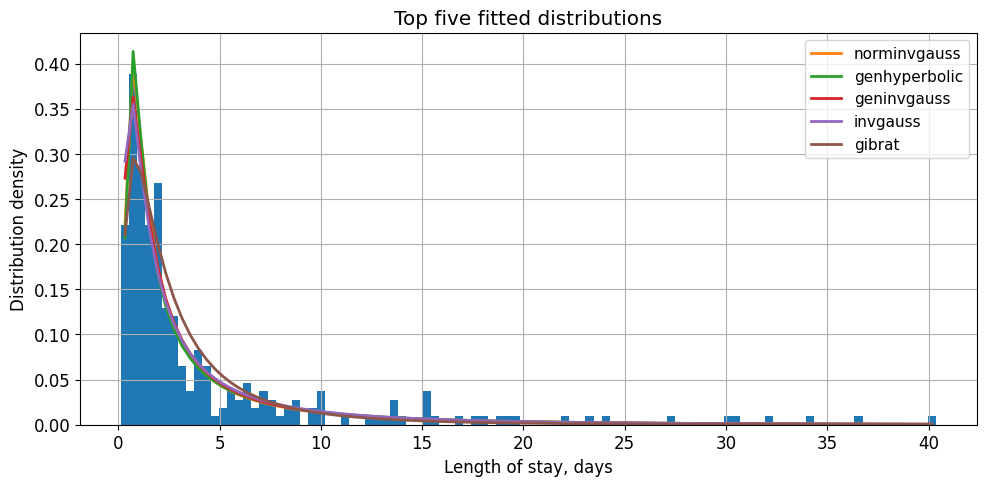

In [16]:
from io import BytesIO
from matplotlib import pyplot as plt
from base64 import b64encode, b64decode
from IPython.display import Image

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,5))
f2.hist()
f2.plot_pdf()
plt.legend(fontsize='11', loc='upper right')
plt.title('Top five fitted distributions')
plt.xlabel('Length of stay, days')
plt.ylabel('Distribution density')

io = BytesIO()
plt.tight_layout(pad=1)
plt.savefig(io, format='png')
io.seek(0)
png_encoded = b64encode(io.read())

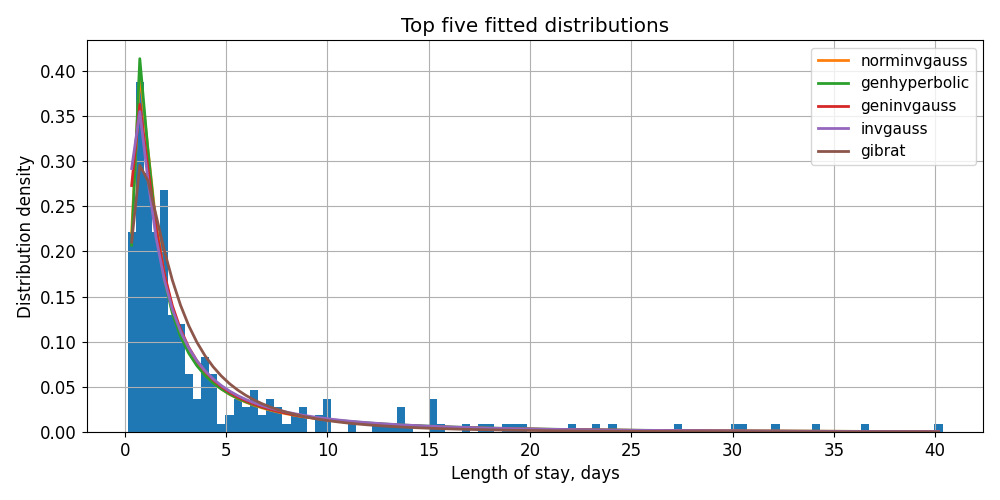

In [17]:
Image(b64decode(png_encoded))